This tutorial uses the same example as the [example introduction](./example_introduction.ipynb).
In other words:

In [1]:
# Module we will use
import chaospy
import numpy
from matplotlib import pyplot

def model_predictor(coordinates, parameters):
    """Over simplistic model function."""
    param_I, param_a = parameters
    return param_I*numpy.e**(-param_a*coordinates)

# The spatio-temporal coordinates 
coordinates = numpy.linspace(0, 10, 1000)

# The distribution of the parameters
distribution_I = chaospy.Normal(1.5, 0.2)
distribution_a = chaospy.Uniform(0.1, 0.2)
distribution = chaospy.J(distribution_I, distribution_a)

## Pseudo-Spectral Projection

Pseudo-spectral projection method is one of two non-intrusive polynomial chaos expansion methods.
(The other being point collocation method.)
In a nutshell it can be performed as follows:

* Generate nodes $Q_1, ..., Q_N$ and weights $W_1, ..., W_N$ from a quadrature integration scheme.
* Use nodes to create model predictions $U_1, ..., U_N$.
* Select an expansion or polynomials $P_1, ..., P_M$, typically orthogonal (with respect to the probability distribution).
* Calculate Fourier coefficients $c_1, ..., c_M$.
* Analyze model approximation $u(I, a, t) = \sum_m c_m(t) P_n(I, a)$ instead of actual model solver. 

In [2]:
polynomial_order = 4
polynomial_expansion = chaospy.orth_ttr(polynomial_order, distribution)
polynomial_expansion[:6].round(4)

polynomial([1.0, -0.15+q1, -1.5+q0, 0.0217-0.3*q1+q1**2,
            0.225-1.5*q1-0.15*q0+q0*q1, 2.21-3.0*q0+q0**2])

In addition we need abscissas and weights from an quadrature scheme:

(array([[0.59745083, 1.0846304 , 1.70465113, 2.40254917],
        [0.10159199, 0.19180156, 0.16621267, 0.13378733]]),
 array([9.08072402e-07, 4.50865354e-03, 3.81215708e-02, 3.48982953e-06]))

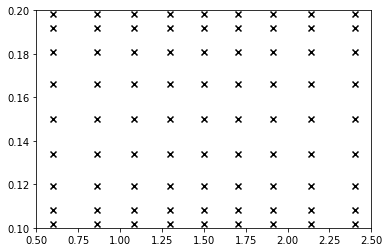

In [3]:
quadrature_order = 8
abscissas, weights = chaospy.generate_quadrature(quadrature_order, distribution, rule="gaussian")

pyplot.axis([0.5, 2.5, 0.1, 0.2])
pyplot.scatter(*abscissas, color="k", marker="x")
abscissas[:, ::25], weights[::25]

These can then be used to create an polynomial approximation as follows:

In [4]:
evaluations = [model_predictor(coordinates, abscissa) for abscissa in abscissas.T]
foo_approx = chaospy.fit_quadrature(polynomial_expansion, abscissas, weights, evaluations)
foo_approx[:5].round(3)

polynomial([q0, q0-0.01*q0*q1, q0-0.02*q0*q1, q0-0.03*q0*q1,
            q0-0.04*q0*q1+0.001*q0*q1**2])

The expected value and variance is calculated as before:

(array([1.5       , 1.4977495 , 1.4955025 , 1.493259  , 1.49101899]),
 array([0.2       , 0.19970041, 0.19940224, 0.19910548, 0.19881013]))

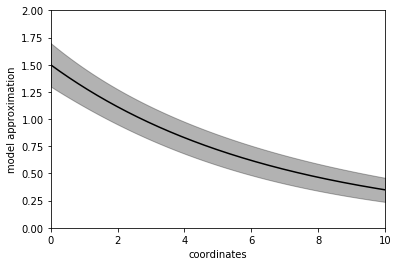

In [5]:
expected = chaospy.E(foo_approx, distribution)
std = chaospy.Std(foo_approx, distribution)

pyplot.xlabel("coordinates")
pyplot.ylabel("model approximation")
pyplot.axis([0, 10, 0, 2])
pyplot.fill_between(coordinates, expected-std, expected+std, alpha=0.3, color="k")
pyplot.plot(coordinates, expected, "k-")

expected[:5], std[:5]